approximate_method to solve GAP problem

In [1]:
import os
import numpy as np
import random
import csv
greedy_results = []
def read_gap_dataset(file_path):
    with open(file_path, "r") as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]
    
    index = 0
    num_instances = int(lines[index])  # First line contains the number of instances
    index += 1
    
    def read_matrix(rows, cols):
        nonlocal index
        matrix = []
        while len(matrix) < rows:
            row_values = []
            while len(row_values) < cols:
                row_values.extend(map(int, lines[index].split()))
                index += 1
            matrix.append(row_values[:cols])
        return matrix
    
    instances = []
    for _ in range(num_instances):
        num_servers, num_users = map(int, lines[index].split())
        index += 1
        
        utilities = read_matrix(num_servers, num_users)
        vm_allocations = read_matrix(num_servers, num_users)
        capacities = list(map(int, lines[index].split()))
        index += 1
        
        instances.append((np.array(utilities), np.array(vm_allocations), np.array(capacities)))
    
    return instances

def greedy_gap(utilities, vm_allocations, capacities):
    num_servers, num_users = utilities.shape
    assignments = [-1] * num_users  # Initialize assignments (-1 means unassigned)
    remaining_capacities = capacities.copy()
    
    # Randomly shuffle user order before sorting
    users = list(range(num_users))
    random.shuffle(users)
    users.sort(key=lambda u: -np.max(utilities[:, u]))
    
    for user in users:
        best_server = -1
        best_ratio = -np.inf
        best_servers = []
        
        for server in range(num_servers):
            if vm_allocations[server][user] <= remaining_capacities[server]:
                ratio = utilities[server][user] / vm_allocations[server][user]
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_servers = [server]
                elif ratio == best_ratio:
                    best_servers.append(server)
        
        if best_servers:
            best_server = random.choice(best_servers)  # Random tie-breaking
            assignments[user] = best_server
            remaining_capacities[best_server] -= vm_allocations[best_server][user]
    
    total_profit = sum(utilities[assignments[u]][u] for u in range(num_users) if assignments[u] != -1)
    return assignments, total_profit

if __name__ == "__main__":
    folder_path = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\gap_dataset_files"  # Folder containing .txt datasets
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]  # Get all .txt files
    
    # Sort files numerically (ensuring they are processed in ascending order like gap1.txt, gap2.txt, etc.)
    file_names.sort(key=lambda f: int(f.split('gap')[1].split('.txt')[0]))
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        instances = read_gap_dataset(file_path)
        
        for instance_id, (utilities, vm_allocations, capacities) in enumerate(instances):
            print(f"\nProcessing Instance {instance_id + 1} from {file_name}")
            assignments, total_profit = greedy_gap(utilities, vm_allocations, capacities)
            
            print(f"Task Assignments: {assignments}")
            print(f"Total Approximate Profit: {total_profit}")
            greedy_results.append((file_name, instance_id + 1, assignments, float(total_profit)))
    output_file = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\greedy_results.csv"
    with open(output_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Filename", "Instance", "Assignments", "Total_Profit"])
        for row in greedy_results:
            writer.writerow(row)

    print(f"\n✅ Results saved to {output_file}")



Processing Instance 1 from gap1.txt
Task Assignments: [4, 1, 2, 3, 0, 3, 0, 1, 0, 1, 3, 4, 4, 0, 2]
Total Approximate Profit: 306

Processing Instance 2 from gap1.txt
Task Assignments: [2, 0, 0, 2, 2, 4, 3, 1, 3, 1, 2, 1, -1, 0, 4]
Total Approximate Profit: 290

Processing Instance 3 from gap1.txt
Task Assignments: [1, 4, 1, 3, 2, 2, 1, 0, 0, 1, 3, 4, 0, 3, 0]
Total Approximate Profit: 318

Processing Instance 4 from gap1.txt
Task Assignments: [1, 4, 2, 4, 4, 0, 0, 1, 1, -1, 2, 2, 3, 3, 1]
Total Approximate Profit: 301

Processing Instance 5 from gap1.txt
Task Assignments: [2, 4, 3, 3, 1, 4, 4, 2, 2, 1, 0, 1, 3, 4, 0]
Total Approximate Profit: 296

Processing Instance 1 from gap2.txt
Task Assignments: [3, 4, 0, 3, 2, 2, 1, 2, 0, 2, 0, 4, 3, 0, 1, 1, 3, 3, 1, 0]
Total Approximate Profit: 406

Processing Instance 2 from gap2.txt
Task Assignments: [4, 2, 4, 3, 0, 2, 0, 1, 4, 2, 4, 1, 1, 1, 3, 1, 3, 2, 3, 0]
Total Approximate Profit: 400

Processing Instance 3 from gap2.txt
Task Assignmen

optimal method

In [2]:


import os
import csv
import pulp
optimal_results = []

def read_gap_instances(file_path):
    with open(file_path, "r") as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]
    
    index = 0
    num_instances = int(lines[index])
    index += 1

    def read_matrix(rows, cols):
        nonlocal index
        matrix = []
        while len(matrix) < rows:
            row_values = []
            while len(row_values) < cols:
                row_values.extend(map(int, lines[index].split()))
                index += 1
            matrix.append(row_values[:cols])
        return matrix

    instances = []
    for _ in range(num_instances):
        num_servers, num_users = map(int, lines[index].split())
        index += 1

        utility = read_matrix(num_servers, num_users)
        vm_allocation = read_matrix(num_servers, num_users)
        server_capacity = list(map(int, lines[index].split()))
        index += 1

        instances.append((utility, vm_allocation, server_capacity))
    
    return instances

def solve_gap_optimally(utility, vm_allocation, server_capacity, instance_id, file_name):
    num_servers = len(utility)
    num_users = len(utility[0])

    problem = pulp.LpProblem(f"GAP_Instance_{instance_id}_from_{file_name}", pulp.LpMaximize)

    # Binary Decision Variables
    x = [[pulp.LpVariable(f"x_{i}_{j}_{instance_id}", cat='Binary') for j in range(num_users)] for i in range(num_servers)]

    # Objective Function
    problem += pulp.lpSum(utility[i][j] * x[i][j] for i in range(num_servers) for j in range(num_users))

    # Constraints
    for j in range(num_users):
        problem += pulp.lpSum(x[i][j] for i in range(num_servers)) == 1

    for i in range(num_servers):
        problem += pulp.lpSum(vm_allocation[i][j] * x[i][j] for j in range(num_users)) <= server_capacity[i]

    problem.solve()

    # Prepare output
    assignments = [-1] * num_users
    for i in range(num_servers):
        for j in range(num_users):
            if pulp.value(x[i][j]) == 1:
                assignments[j] = i

    total_utility = pulp.value(problem.objective)

    # Output
    print(f"\nProcessing Instance {instance_id} from {file_name}")
    print(f"Task Assignments: {assignments}")
    print(f"Total Optimal Utility: {total_utility}")
    optimal_results.append((file_name, instance_id + 1, assignments, float(total_utility)))


if __name__ == "__main__":
    folder_path = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\gap_dataset_files"
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    file_names.sort(key=lambda f: int(f.split('gap')[1].split('.txt')[0]))  # Ensure proper order: gap1, gap2...

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        instances = read_gap_instances(file_path)

        for instance_id, (utility, vm_allocation, server_capacity) in enumerate(instances, start=1):
            solve_gap_optimally(utility, vm_allocation, server_capacity, instance_id, file_name)
    output_file = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\optimal_results.csv"
    with open(output_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Filename", "Instance", "Assignments", "Total_Profit"])
        for row in optimal_results:
            writer.writerow(row)

    print(f"\n✅ Results saved to {output_file}")


Processing Instance 1 from gap1.txt
Task Assignments: [1, 1, 3, 2, 0, 4, 0, 1, 0, 3, 3, 3, 0, 4, 2]
Total Optimal Utility: 336.0

Processing Instance 2 from gap1.txt
Task Assignments: [3, 0, 0, 2, 2, 0, 2, 1, 3, 1, 2, 1, 3, 4, 4]
Total Optimal Utility: 327.0

Processing Instance 3 from gap1.txt
Task Assignments: [1, 4, 4, 3, 2, 3, 4, 0, 1, 1, 2, 0, 0, 3, 0]
Total Optimal Utility: 339.0

Processing Instance 4 from gap1.txt
Task Assignments: [2, 4, 1, 4, 0, 0, 4, 1, 0, 3, 2, 2, 3, 4, 1]
Total Optimal Utility: 341.0

Processing Instance 5 from gap1.txt
Task Assignments: [1, 3, 0, 3, 4, 1, 4, 3, 2, 2, 0, 1, 0, 4, 4]
Total Optimal Utility: 326.0

Processing Instance 1 from gap2.txt
Task Assignments: [2, 4, 0, 3, 2, 0, 1, 3, 0, 1, 4, 4, 2, 4, 3, 1, 2, 3, 1, 0]
Total Optimal Utility: 434.0

Processing Instance 2 from gap2.txt
Task Assignments: [4, 2, 4, 3, 0, 2, 0, 3, 2, 1, 1, 1, 1, 4, 4, 3, 3, 3, 2, 0]
Total Optimal Utility: 436.0

Processing Instance 3 from gap2.txt
Task Assignments: [3, 4

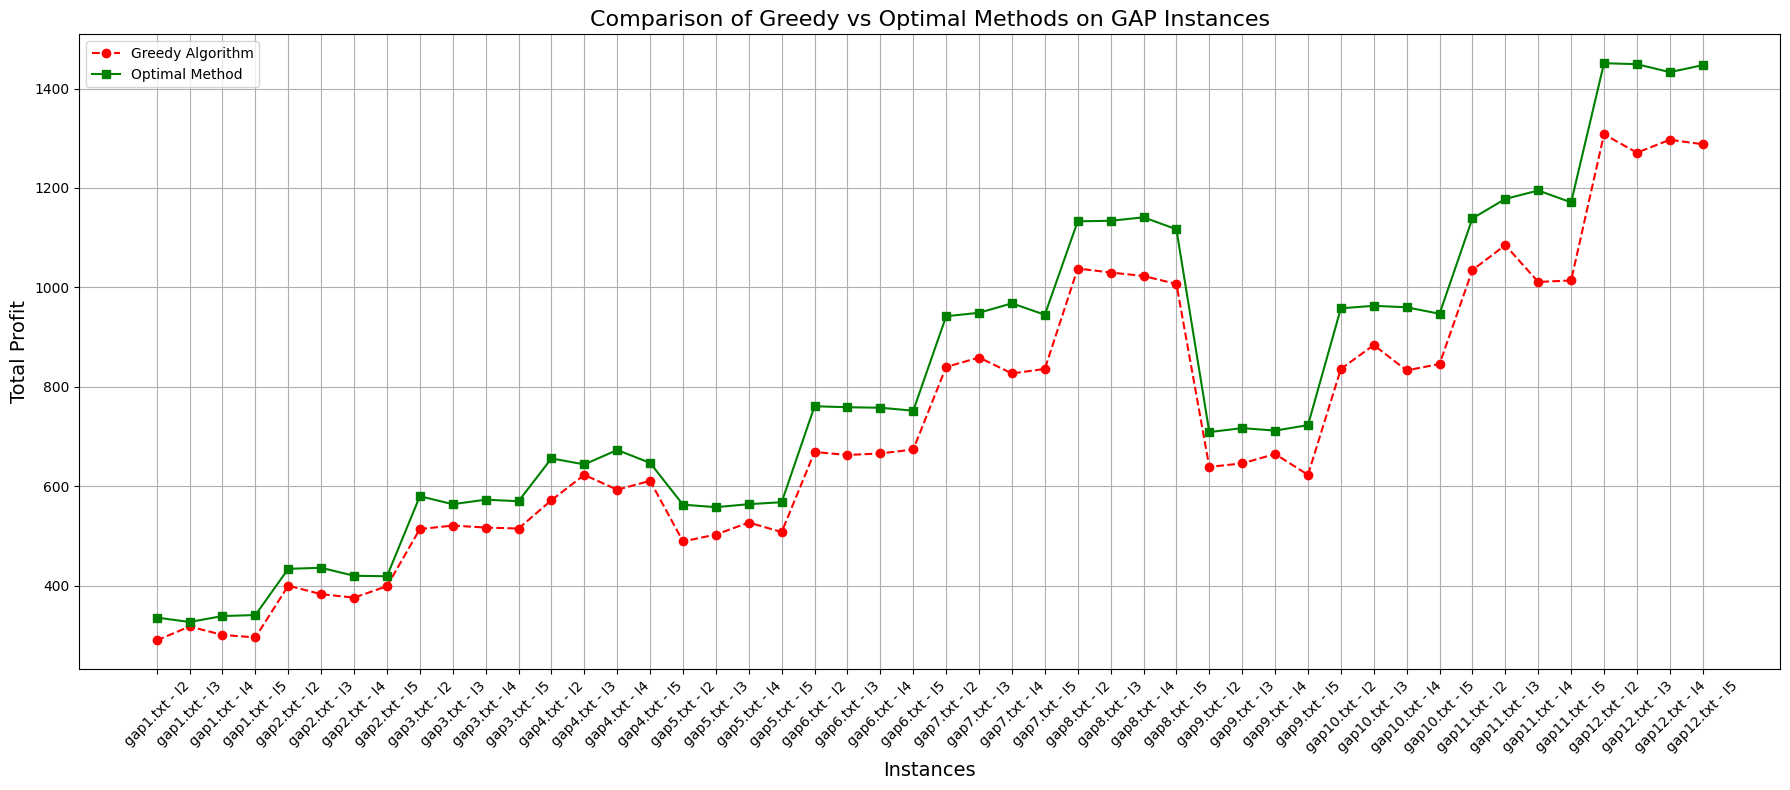

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load result files
greedy_df = pd.read_csv(r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\greedy_results.csv")
optimal_df = pd.read_csv(r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\optimal_results.csv")

# Rename columns
greedy_df.rename(columns={"Total_Profit": "Greedy_Profit"}, inplace=True)
optimal_df.rename(columns={"Total_Profit": "Optimal_Profit"}, inplace=True)

# Merge on Filename and Instance
merged_df = pd.merge(greedy_df, optimal_df, on=["Filename", "Instance"])

# Extract numeric parts for sorting
def extract_sort_key(row):
    filename_number = int(re.search(r'\d+', row["Filename"]).group())
    instance_number = int(row["Instance"])
    return (filename_number, instance_number)

# Sort using the extracted numbers
merged_df["Sort_Key"] = merged_df.apply(extract_sort_key, axis=1)
merged_df.sort_values(by="Sort_Key", inplace=True)
merged_df.drop(columns=["Sort_Key"], inplace=True)

# Create labels
merged_df["Label"] = merged_df["Filename"] + " - I" + merged_df["Instance"].astype(str)

# Plot
plt.figure(figsize=(18, 8))
x = merged_df["Label"]

plt.plot(x, merged_df["Greedy_Profit"], marker='o', linestyle='--', color='red', label="Greedy Algorithm")
plt.plot(x, merged_df["Optimal_Profit"], marker='s', linestyle='-', color='green', label="Optimal Method")

plt.xlabel("Instances", fontsize=14)
plt.ylabel("Total Profit", fontsize=14)
plt.title("Comparison of Greedy vs Optimal Methods on GAP Instances", fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Save and show
plt.tight_layout()
plt.savefig("gap_comparison_plot.png", dpi=300)
plt.show()
